## Neural networks for segmentation

In [ ]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


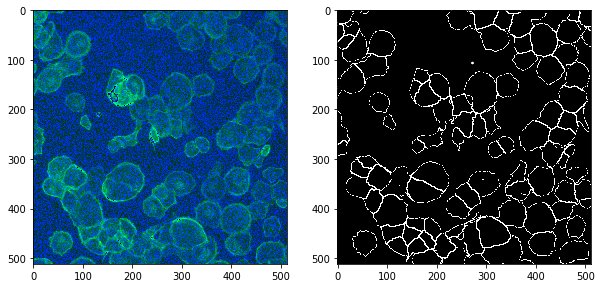

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [4]:
import numpy as np
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data_utils
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

%matplotlib inline

In [5]:
img_path = "BBBC018_v1_images-fixed"
mask_path = "BBBC018_v1_outlines"
train_img_path = os.path.join(img_path, "train")
train_mask_path = os.path.join(mask_path, "train")
test_img_path = os.path.join(img_path, "val")
test_mask_path = os.path.join(mask_path, "val")

In [6]:
img = Image.open("BBBC018_v1_outlines/train/00735-cells.png")
np.array(img)

array([[255, 255, 255, ..., 255, 255, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [7]:
train_images_list = [s.strip().split('-')[0] for s in os.listdir(train_img_path)]
test_images_list = [s.strip().split('-')[0] for s in os.listdir(test_img_path)]
len(train_images_list), len(test_images_list)

(41, 7)

In [8]:
train_images_list, val_images_list = train_test_split(train_images_list, test_size=0.2)
len(train_images_list), len(val_images_list)

(32, 9)

In [9]:
class ImgDataset(data_utils.Dataset):
    def __init__(self,
                 image_dir,
                 image_names,
                 image_transform,
                 mask_dir,
                 mask_transform):
        
        self.image_dir = image_dir
        self.image_names = image_names
        self.image_transform = image_transform

        self.mask_dir = mask_dir
        self.mask_transform = mask_transform
        
        self.loaded_image = []
        self.loaded_mask = []
        for name in self.image_names:
            image_name = "{}-actin.DIB.bmp".format(name)
            mask_name = "{}-cells.png".format(name)
            image = Image.open(os.path.join(self.image_dir, image_name))
            self.loaded_image.append(image)
            mask = Image.open(os.path.join(self.mask_dir, mask_name))
            self.loaded_mask.append(mask)

    def __getitem__(self, i):
        # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        seed = np.random.randint(2147483647)

        image = deepcopy(self.loaded_image[i])
        mask = deepcopy(self.loaded_mask[i])
        
        random.seed(seed)
        image = self.image_transform(image)

        random.seed(seed)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        mask = np.array(mask, dtype=np.int64)
        mask = np.clip(mask, 0, 1)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return len(self.image_names)

In [10]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [11]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, activation, batchnorm=False, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)
        
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "leaky":
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError("!!!!")
            
        if batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(self.out_channels)
            self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        else:
            self.batchnorm1, self.batchnorm2 = None, None
            
        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        if self.batchnorm1 is not None:
            x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.batchnorm2 is not None:
            x = self.batchnorm2(x)
        x = self.activation(x)
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

In [12]:
class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 activation,
                 batchnorm=False,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "leaky":
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError("!!!!")
            
        if batchnorm:
            self.batchnorm1 = nn.BatchNorm2d(self.out_channels)
            self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        else:
            self.batchnorm1, self.batchnorm2 = None, None
        
        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = self.conv1(x)
        if self.batchnorm1 is not None:
            x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.batchnorm2 is not None:
            x = self.batchnorm2(x)
        x = self.activation(x)
        return x

In [13]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, activation='relu', batchnorm=False, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth
        
        self.activation = activation
        self.batchnorm = batchnorm

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, activation=self.activation, batchnorm=self.batchnorm, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, activation=self.activation, batchnorm=self.batchnorm,
                             up_mode=up_mode, merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [14]:
def get_loss_and_iou(dl, model, class_weights):
    loss = 0.0
    iou = 0.0
    with torch.cuda.device(1):
        class_weights = torch.FloatTensor(class_weights).cuda()
    for X, y in dl:
        with torch.cuda.device(1):
            X, y = Variable(X).cuda(), Variable(y).cuda()
            output = model(X)
            
            loss_ = nn.CrossEntropyLoss(weight=class_weights)(output, y)
        loss += loss_.item()
        pred = output.detach().cpu().numpy()
        pred = np.argmax(pred, axis=1)
        gt = y.detach().cpu().numpy()
        iou += calc_iou(pred, gt)
    loss = loss / len(dl)
    iou = iou / len(dl)
    return loss, iou

In [15]:
means = (0.20166926, 0.28220195, 0.31729624)
stds = (0.20769505, 0.18813899, 0.16692209)

train_image_transform = transforms.Compose([
#     transforms.RandomCrop(size=256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

train_mask_transform = transforms.Compose([
#     transforms.RandomCrop(size=256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180)
])

val_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

val_mask_transform = None

In [16]:
train_dataset = ImgDataset(image_dir=train_img_path,
                           image_names=train_images_list,
                           image_transform=train_image_transform,
                           mask_dir=train_mask_path,
                           mask_transform=train_mask_transform)

val_dataset = ImgDataset(image_dir=train_img_path,
                         image_names=val_images_list,
                         image_transform=val_image_transform,
                         mask_dir=train_mask_path,
                         mask_transform=val_mask_transform)

In [17]:
len(train_dataset), len(val_dataset)

(32, 9)

In [18]:
train_dl = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = data_utils.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [187]:
with torch.cuda.device(1):
    unet = UNet(2, in_channels=3, depth=2, start_filts=16).cuda()

In [188]:
train_loss, train_iou, val_loss, val_iou = [], [], [], []
optim = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [219]:
class_weights = [1, 2]
with torch.cuda.device(1):
    class_weights_tensor = torch.FloatTensor(class_weights).cuda()

In [211]:
from IPython.display import clear_output

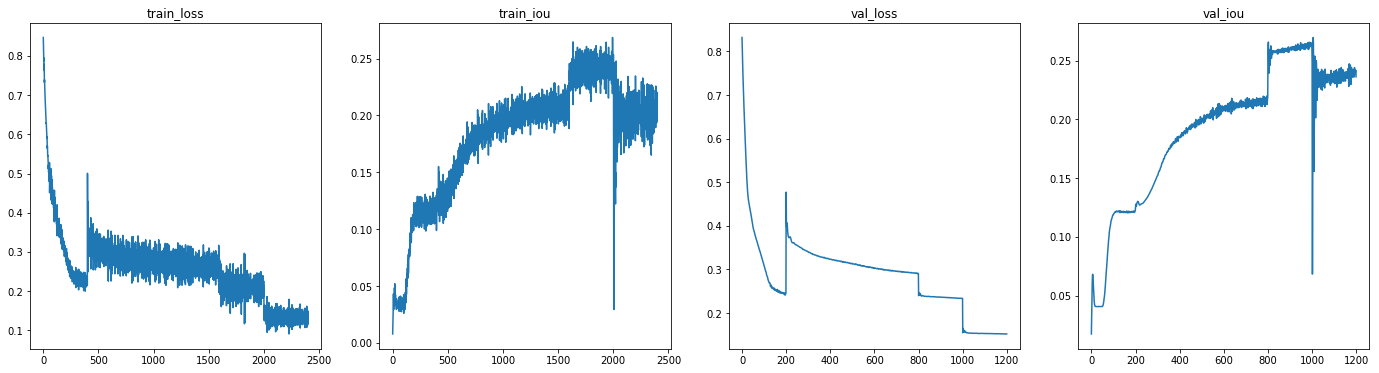

100%|██████████| 200/200 [04:20<00:00,  1.31s/it]


In [220]:
for i in tqdm(range(200)):
    unet.train()
    for X, y in train_dl:
        with torch.cuda.device(1):
            X = Variable(X).cuda()
            y = Variable(y).cuda()
            output = unet(X)
            loss_ = nn.CrossEntropyLoss(weight=class_weights_tensor)(output, y)
            loss_.backward()
            optim.step()
            optim.zero_grad()
        train_loss.append(loss_.item())
        pred = output.detach().cpu().numpy()
        pred = np.argmax(pred, axis=1)
        gt = y.detach().cpu().numpy()
        train_iou.append(calc_iou(pred, gt))
    unet.eval()
    loss, iou = get_loss_and_iou(val_dl, unet, class_weights=class_weights)
    val_loss.append(loss)
    val_iou.append(iou)
    
    clear_output(True)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.subplot(1, 4, 2)
    plt.plot(train_iou)
    plt.title('train_iou')
    plt.subplot(1, 4, 3)
    plt.plot(val_loss)
    plt.title('val_loss')
    plt.subplot(1, 4, 4)
    plt.plot(val_iou)
    plt.title('val_iou')
    plt.show()

In [33]:
len(val_dataset)

9

In [221]:
unet.eval()
for X, y in val_dl:
    with torch.cuda.device(1):
        X = Variable(X).cuda()
        output = unet(X)
    prediction = output.detach().cpu().numpy()
    gt = y.detach().cpu().numpy()

In [222]:
prediction.shape, gt.shape

((9, 2, 512, 512), (9, 512, 512))

In [223]:
prediction = prediction.argmax(axis=1)
prediction.shape

(9, 512, 512)

In [224]:
gt.max(), prediction.max()

(1, 1)

In [225]:
gt.dtype, prediction.dtype

(dtype('int64'), dtype('int64'))

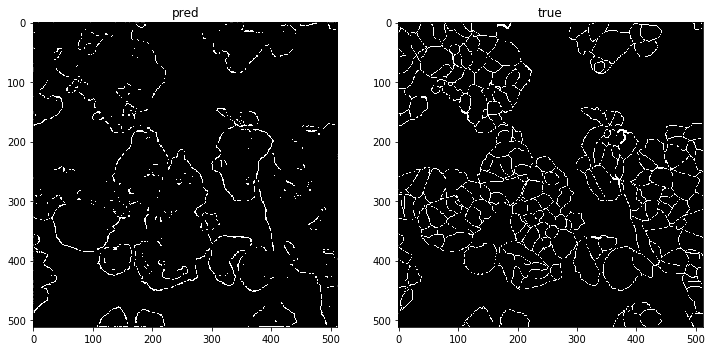

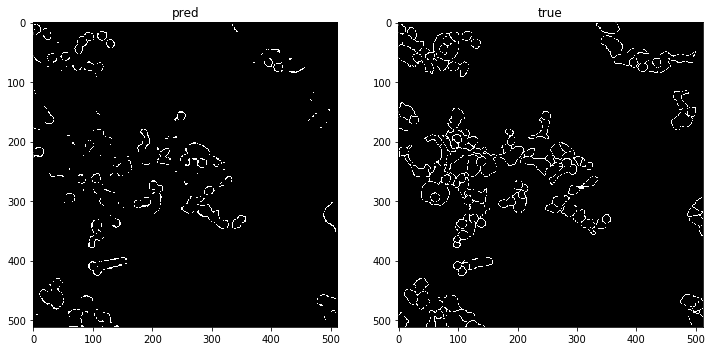

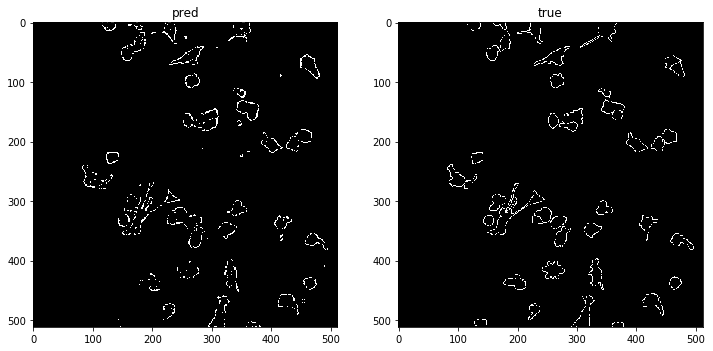

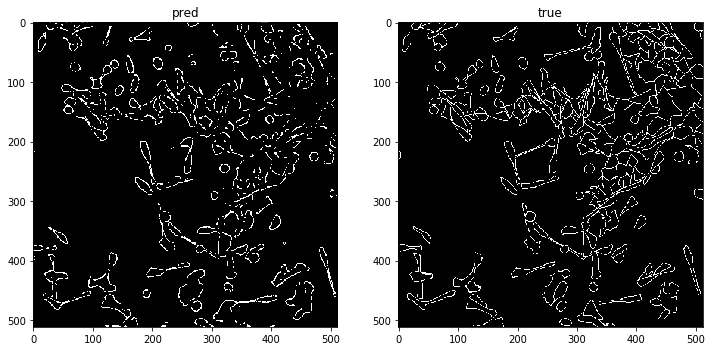

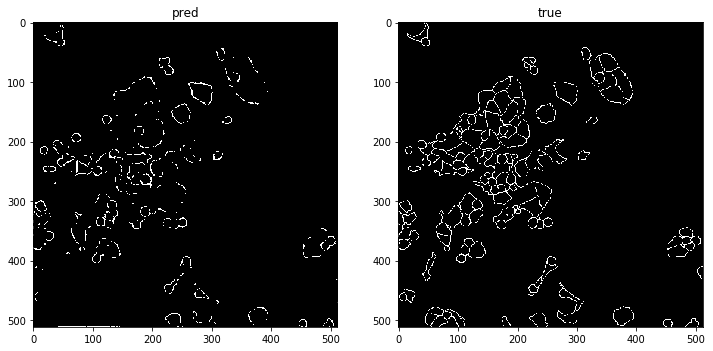

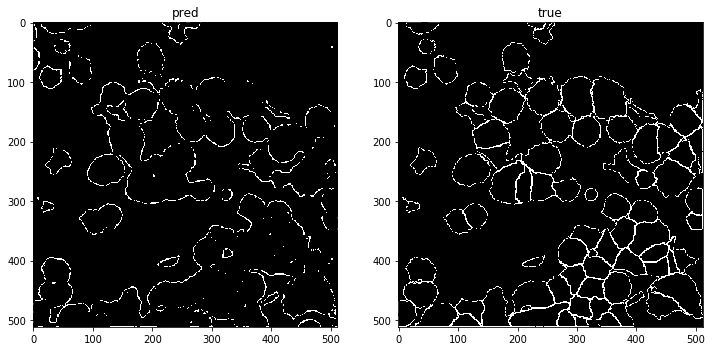

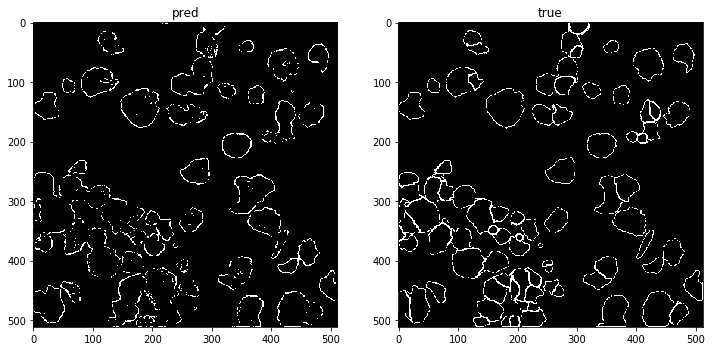

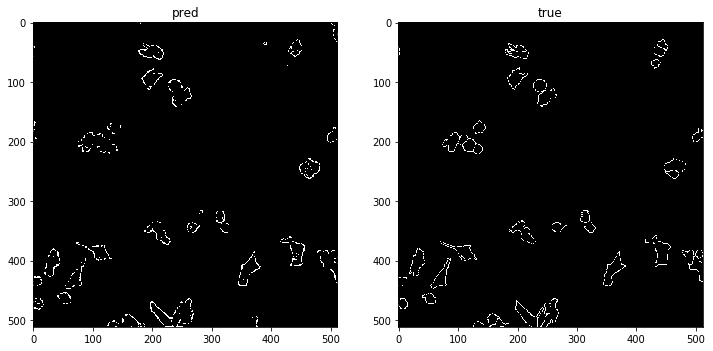

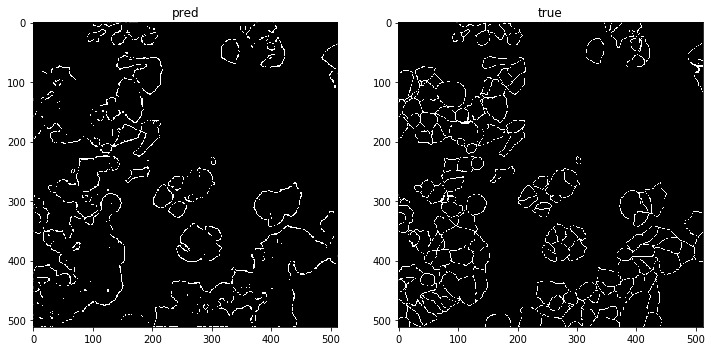

In [226]:
for p, g in zip(prediction, gt):
    p_im = Image.fromarray(p.astype(np.uint8) * 255, mode='L')
    g_im = Image.fromarray(g.astype(np.uint8) * 255, mode='L')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(p_im)
    plt.title('pred')
    plt.subplot(1, 2, 2)
    plt.imshow(g_im)
    plt.title('true')
    plt.show()

In [23]:
test_dataset = ImgDataset(image_dir=test_img_path,
                         image_names=test_images_list,
                         image_transform=val_image_transform,
                         mask_dir=test_mask_path,
                         mask_transform=val_mask_transform)
test_dl = data_utils.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [228]:
unet.eval()
for X, y in test_dl:
    with torch.cuda.device(1):
        X = Variable(X).cuda()
        output = unet(X)
    prediction = output.detach().cpu().numpy()
    gt = y.detach().cpu().numpy()

In [229]:
prediction.shape, gt.shape

((7, 2, 512, 512), (7, 512, 512))

In [230]:
prediction = prediction.argmax(axis=1)
prediction.shape

(7, 512, 512)

In [231]:
print("Test IOU: {}".format(calc_iou(prediction, gt)))

Test IOU: 0.1944255870645231


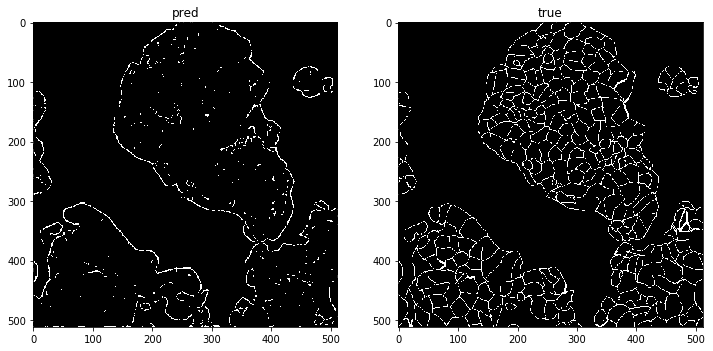

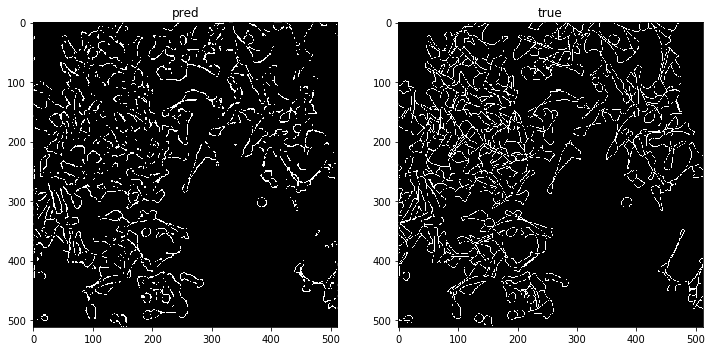

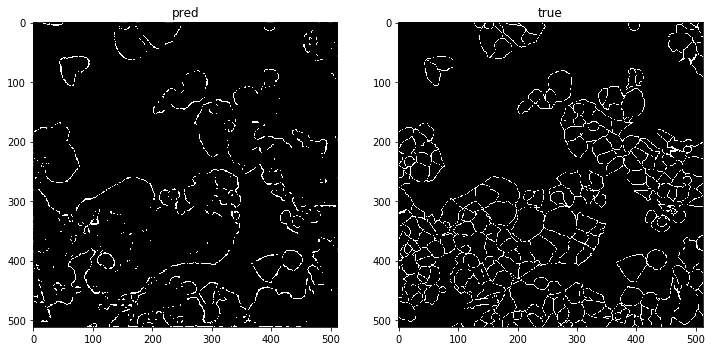

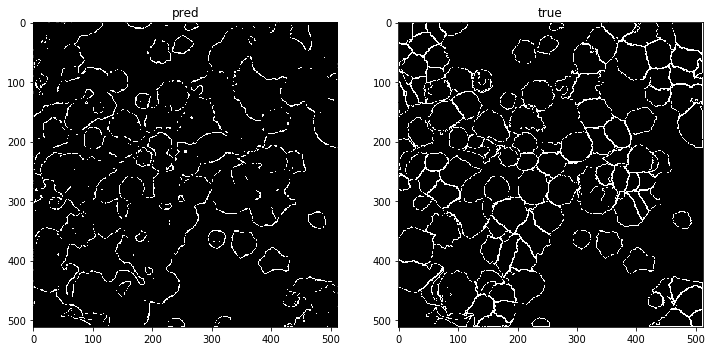

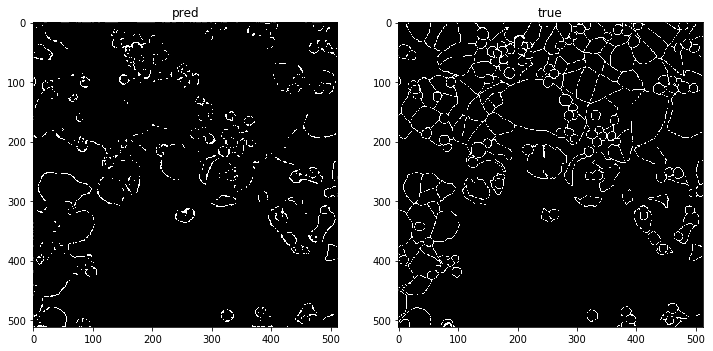

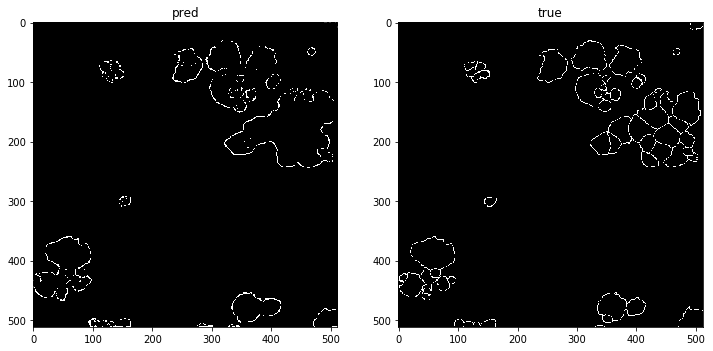

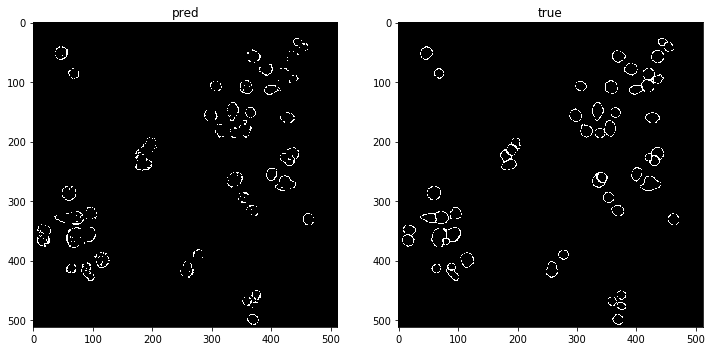

In [232]:
for p, g in zip(prediction, gt):
    p_im = Image.fromarray(p.astype(np.uint8) * 255, mode='L')
    g_im = Image.fromarray(g.astype(np.uint8) * 255, mode='L')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(p_im)
    plt.title('pred')
    plt.subplot(1, 2, 2)
    plt.imshow(g_im)
    plt.title('true')
    plt.show()

## Попробуем увеличить глубину и добавить батчнорм

In [233]:
with torch.cuda.device(1):
    unet = UNet(2, in_channels=3, depth=3, start_filts=16, batchnorm=True).cuda()

In [234]:
train_loss, train_iou, val_loss, val_iou = [], [], [], []
optim = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [251]:
class_weights = [1, 5]
with torch.cuda.device(1):
    class_weights_tensor = torch.FloatTensor(class_weights).cuda()

In [252]:
from IPython.display import clear_output

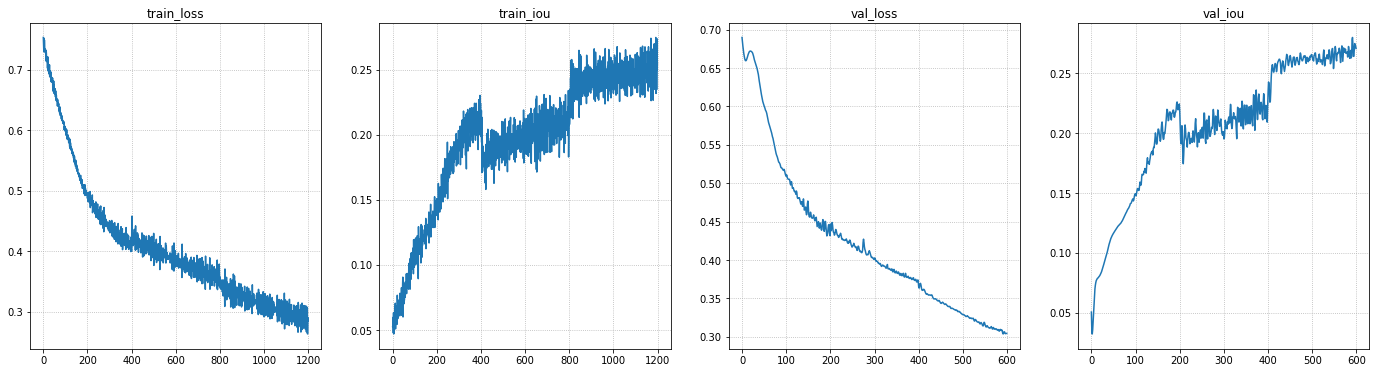

100%|██████████| 200/200 [05:15<00:00,  1.59s/it]


In [253]:
for i in tqdm(range(200)):
    unet.train()
    for X, y in train_dl:
        with torch.cuda.device(1):
            X = Variable(X).cuda()
            y = Variable(y).cuda()
            output = unet(X)
            loss_ = nn.CrossEntropyLoss(weight=class_weights_tensor)(output, y)
            loss_.backward()
            optim.step()
            optim.zero_grad()
        train_loss.append(loss_.item())
        pred = output.detach().cpu().numpy()
        pred = np.argmax(pred, axis=1)
        gt = y.detach().cpu().numpy()
        train_iou.append(calc_iou(pred, gt))
    unet.eval()
    loss, iou = get_loss_and_iou(val_dl, unet, class_weights=class_weights)
    val_loss.append(loss)
    val_iou.append(iou)
    
    clear_output(True)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 2)
    plt.plot(train_iou)
    plt.title('train_iou')
    plt.grid(ls=':')
    plt.subplot(1, 4, 3)
    plt.plot(val_loss)
    plt.title('val_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 4)
    plt.plot(val_iou)
    plt.title('val_iou')
    plt.grid(ls=':')
    plt.show()

In [254]:
unet.eval()
for X, y in test_dl:
    with torch.cuda.device(1):
        X = Variable(X).cuda()
        output = unet(X)
    prediction = output.detach().cpu().numpy()
    gt = y.detach().cpu().numpy()

In [255]:
prediction.shape, gt.shape

((7, 2, 512, 512), (7, 512, 512))

In [256]:
prediction = prediction.argmax(axis=1)
prediction.shape

(7, 512, 512)

In [257]:
print("Test IOU: {}".format(calc_iou(prediction, gt)))

Test IOU: 0.25130201522816087


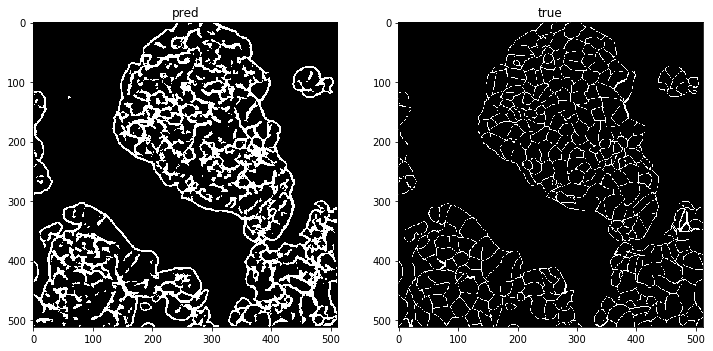

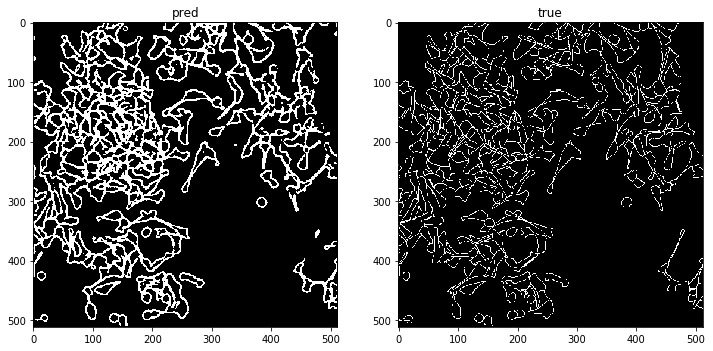

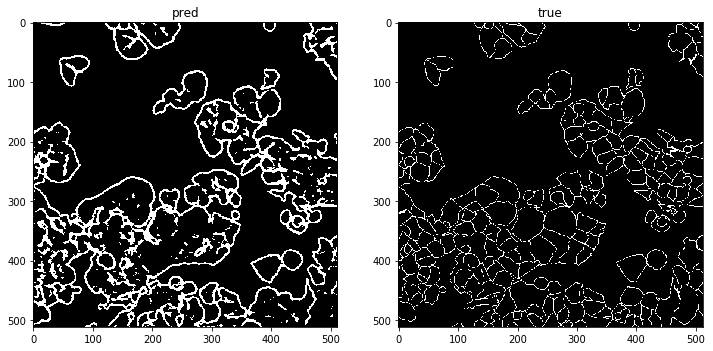

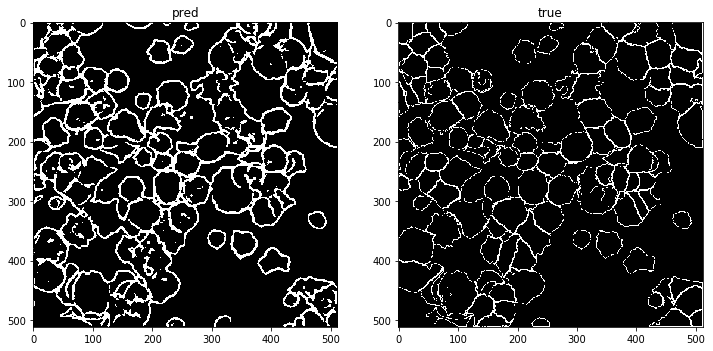

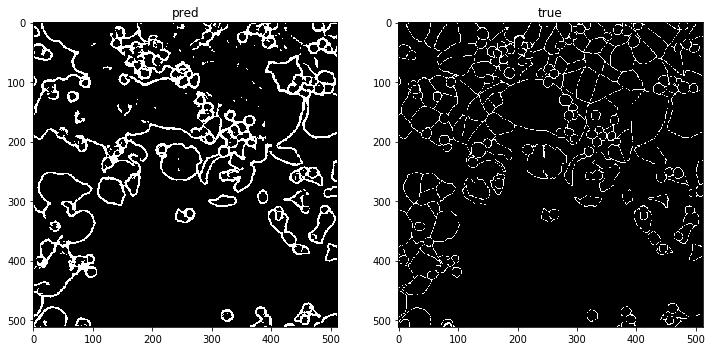

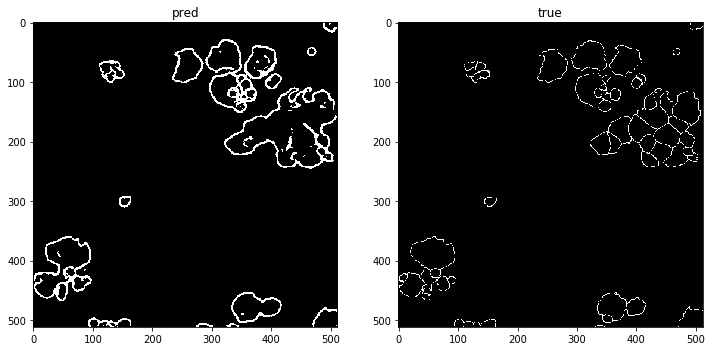

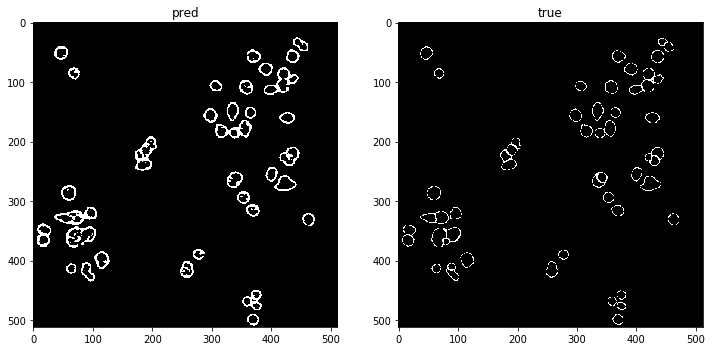

In [258]:
for p, g in zip(prediction, gt):
    p_im = Image.fromarray(p.astype(np.uint8) * 255, mode='L')
    g_im = Image.fromarray(g.astype(np.uint8) * 255, mode='L')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(p_im)
    plt.title('pred')
    plt.subplot(1, 2, 2)
    plt.imshow(g_im)
    plt.title('true')
    plt.show()

## Попробуем c leakyRelu

In [259]:
with torch.cuda.device(1):
    unet = UNet(2, in_channels=3, depth=3, start_filts=16, batchnorm=True, activation='leaky').cuda()

In [260]:
train_loss, train_iou, val_loss, val_iou = [], [], [], []
optim = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [280]:
class_weights = [1, 5]
with torch.cuda.device(1):
    class_weights_tensor = torch.FloatTensor(class_weights).cuda()

In [281]:
from IPython.display import clear_output

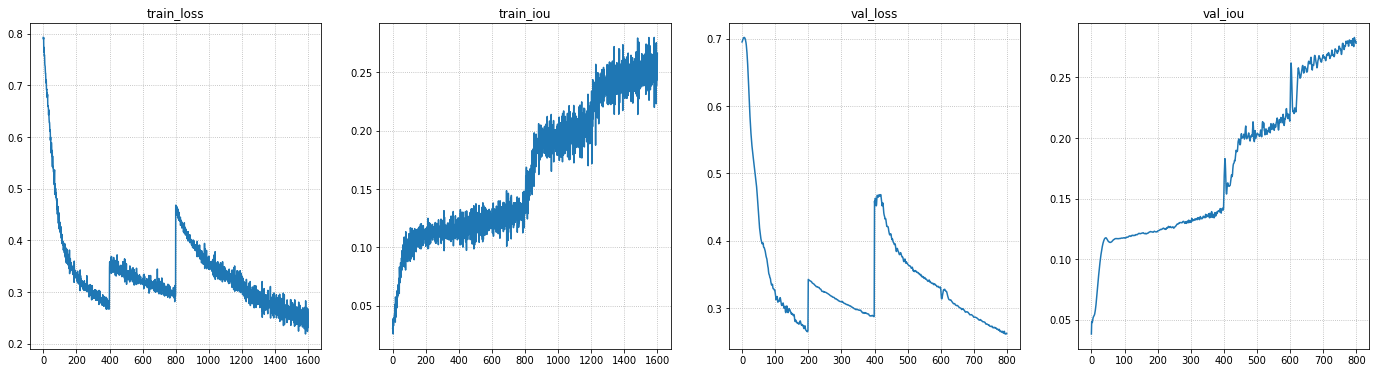

100%|██████████| 200/200 [05:22<00:00,  1.62s/it]


In [282]:
for i in tqdm(range(200)):
    unet.train()
    for X, y in train_dl:
        with torch.cuda.device(1):
            X = Variable(X).cuda()
            y = Variable(y).cuda()
            output = unet(X)
            loss_ = nn.CrossEntropyLoss(weight=class_weights_tensor)(output, y)
            loss_.backward()
            optim.step()
            optim.zero_grad()
        train_loss.append(loss_.item())
        pred = output.detach().cpu().numpy()
        pred = np.argmax(pred, axis=1)
        gt = y.detach().cpu().numpy()
        train_iou.append(calc_iou(pred, gt))
    unet.eval()
    loss, iou = get_loss_and_iou(val_dl, unet, class_weights=class_weights)
    val_loss.append(loss)
    val_iou.append(iou)
    
    clear_output(True)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 2)
    plt.plot(train_iou)
    plt.title('train_iou')
    plt.grid(ls=':')
    plt.subplot(1, 4, 3)
    plt.plot(val_loss)
    plt.title('val_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 4)
    plt.plot(val_iou)
    plt.title('val_iou')
    plt.grid(ls=':')
    plt.show()

In [283]:
unet.eval()
for X, y in test_dl:
    with torch.cuda.device(1):
        X = Variable(X).cuda()
        output = unet(X)
    prediction = output.detach().cpu().numpy()
    gt = y.detach().cpu().numpy()

In [284]:
prediction.shape, gt.shape

((7, 2, 512, 512), (7, 512, 512))

In [285]:
prediction = prediction.argmax(axis=1)
prediction.shape

(7, 512, 512)

In [286]:
print("Test IOU: {}".format(calc_iou(prediction, gt)))

Test IOU: 0.25752804231203996


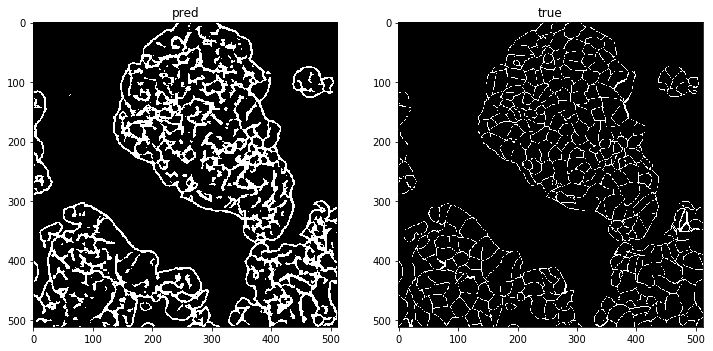

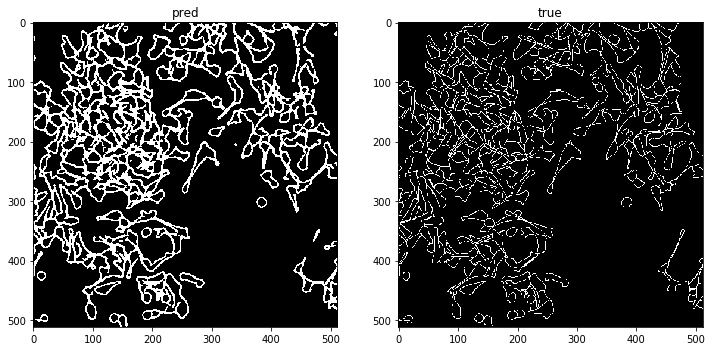

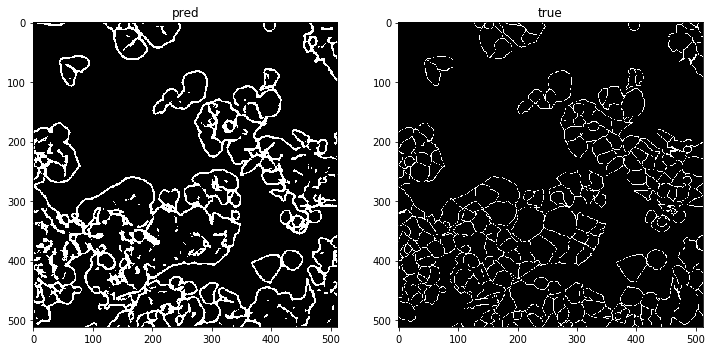

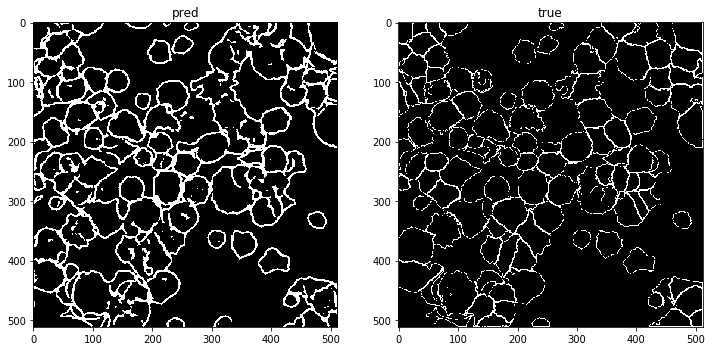

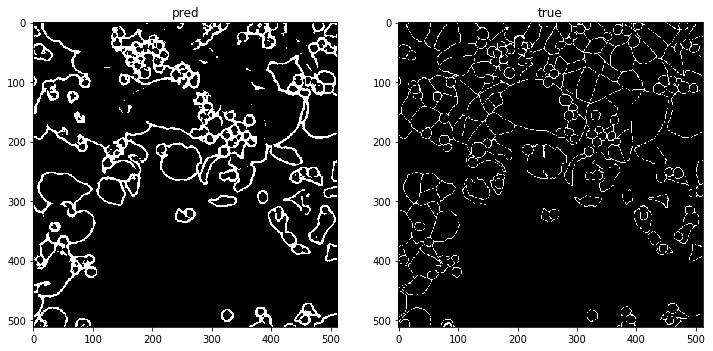

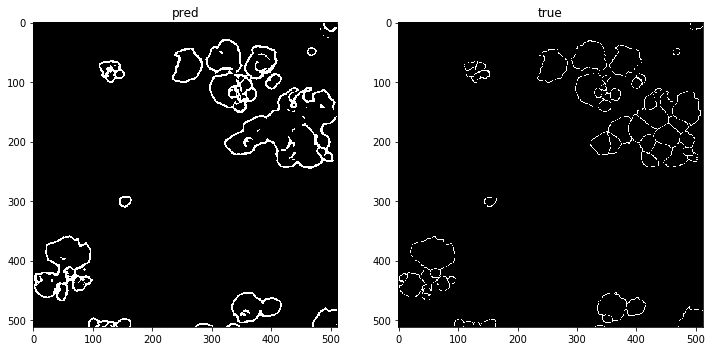

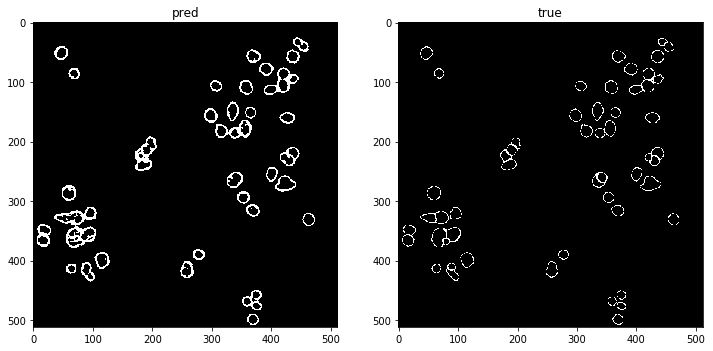

In [287]:
for p, g in zip(prediction, gt):
    p_im = Image.fromarray(p.astype(np.uint8) * 255, mode='L')
    g_im = Image.fromarray(g.astype(np.uint8) * 255, mode='L')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(p_im)
    plt.title('pred')
    plt.subplot(1, 2, 2)
    plt.imshow(g_im)
    plt.title('true')
    plt.show()

## Увеличиваем глубину

In [19]:
means = (0.20166926, 0.28220195, 0.31729624)
stds = (0.20769505, 0.18813899, 0.16692209)

train_image_transform = transforms.Compose([
#     transforms.RandomCrop(size=300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

train_mask_transform = transforms.Compose([
#     transforms.RandomCrop(size=300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180)
])

val_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

val_mask_transform = None

In [20]:
train_dataset = ImgDataset(image_dir=train_img_path,
                           image_names=train_images_list + val_images_list,
                           image_transform=train_image_transform,
                           mask_dir=train_mask_path,
                           mask_transform=train_mask_transform)

val_dataset = ImgDataset(image_dir=train_img_path,
                         image_names=val_images_list,
                         image_transform=val_image_transform,
                         mask_dir=train_mask_path,
                         mask_transform=val_mask_transform)

In [21]:
len(train_dataset), len(val_dataset)

(41, 9)

In [22]:
train_dl = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = data_utils.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [24]:
with torch.cuda.device(1):
    unet = UNet(2, in_channels=3, depth=4, start_filts=16, batchnorm=True, activation='leaky').cuda()

In [25]:
train_loss, train_iou, val_loss, val_iou = [], [], [], []
optim = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [26]:
class_weights = [1, 3]
with torch.cuda.device(1):
    class_weights_tensor = torch.FloatTensor(class_weights).cuda()

In [27]:
from IPython.display import clear_output

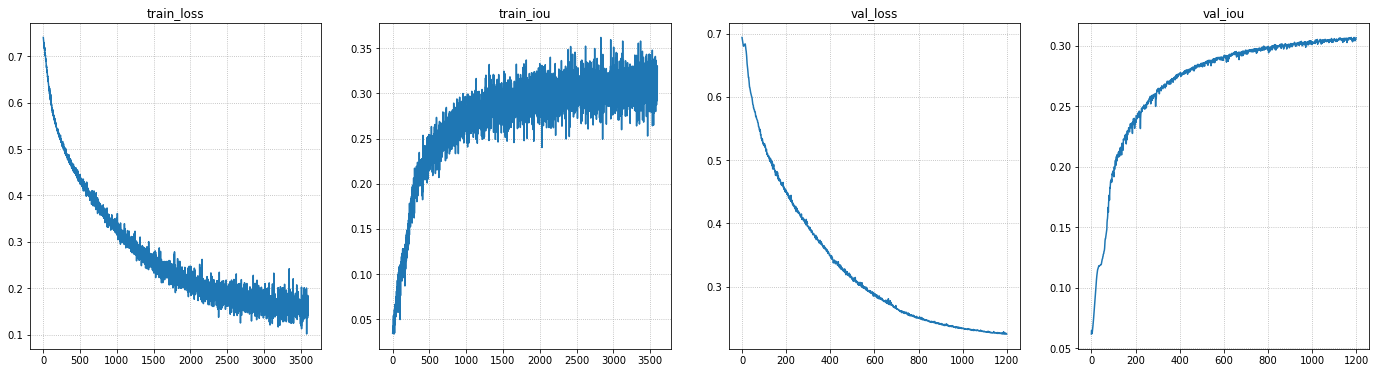

100%|██████████| 600/600 [19:32<00:00,  2.00s/it]


In [29]:
for i in tqdm(range(600)):
    unet.train()
    for X, y in train_dl:
        with torch.cuda.device(1):
            X = Variable(X).cuda()
            y = Variable(y).cuda()
            output = unet(X)
            loss_ = nn.CrossEntropyLoss(weight=class_weights_tensor)(output, y)
            loss_.backward()
            optim.step()
            optim.zero_grad()
        train_loss.append(loss_.item())
        pred = output.detach().cpu().numpy()
        pred = np.argmax(pred, axis=1)
        gt = y.detach().cpu().numpy()
        train_iou.append(calc_iou(pred, gt))
    unet.eval()
    loss, iou = get_loss_and_iou(test_dl, unet, class_weights=class_weights)
    val_loss.append(loss)
    val_iou.append(iou)
    
    clear_output(True)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 2)
    plt.plot(train_iou)
    plt.title('train_iou')
    plt.grid(ls=':')
    plt.subplot(1, 4, 3)
    plt.plot(val_loss)
    plt.title('val_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 4)
    plt.plot(val_iou)
    plt.title('val_iou')
    plt.grid(ls=':')
    plt.show()

In [30]:
unet.eval()
for X, y in test_dl:
    with torch.cuda.device(1):
        X = Variable(X).cuda()
        output = unet(X)
    prediction = output.detach().cpu().numpy()
    gt = y.detach().cpu().numpy()

In [31]:
prediction.shape, gt.shape

((7, 2, 512, 512), (7, 512, 512))

In [32]:
prediction = prediction.argmax(axis=1)
prediction.shape

(7, 512, 512)

In [33]:
print("Test IOU: {}".format(calc_iou(prediction, gt)))

Test IOU: 0.306757721256164


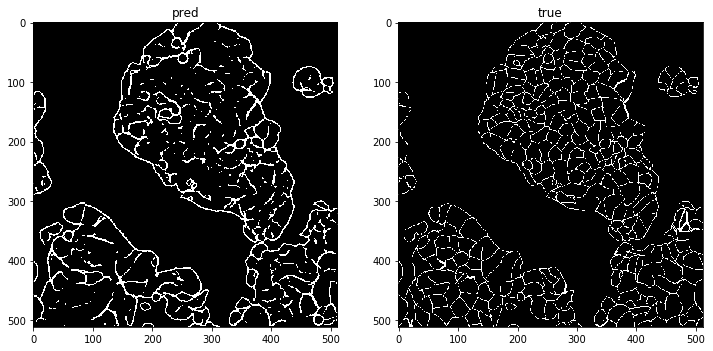

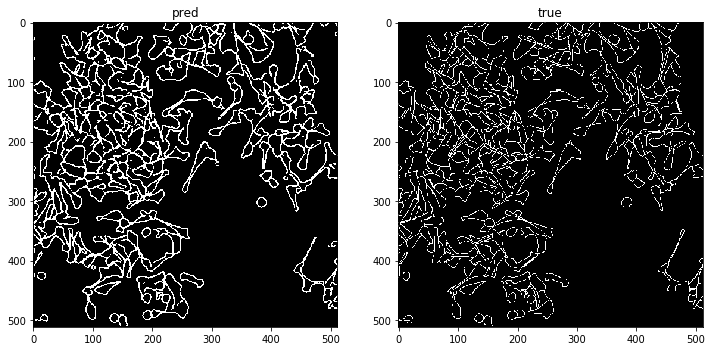

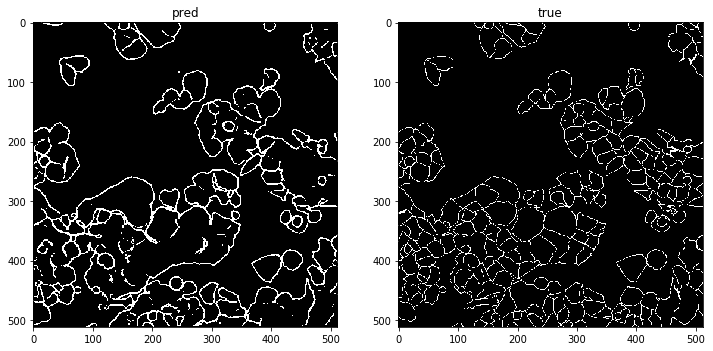

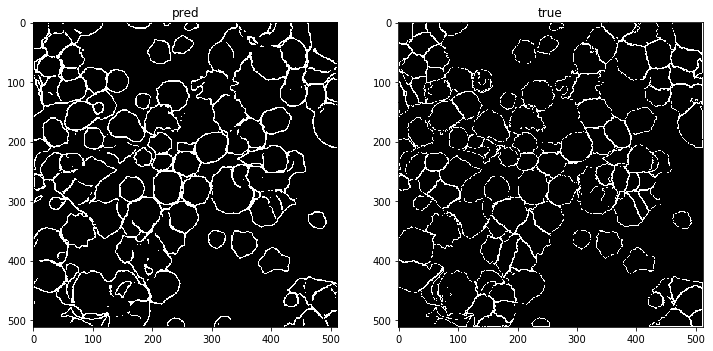

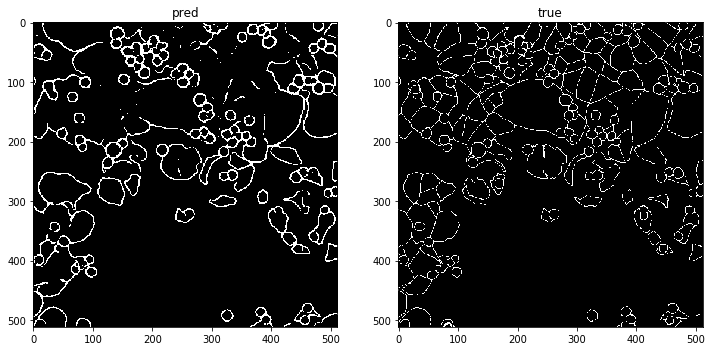

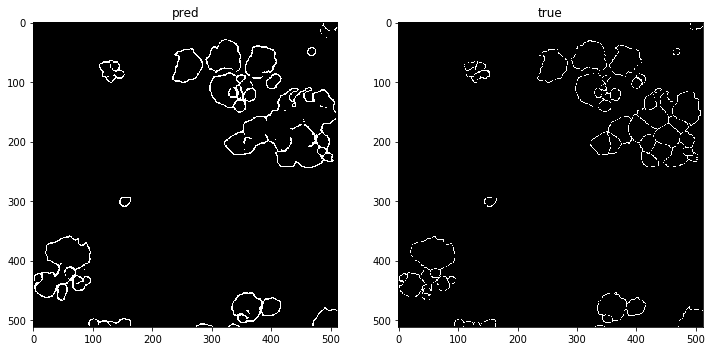

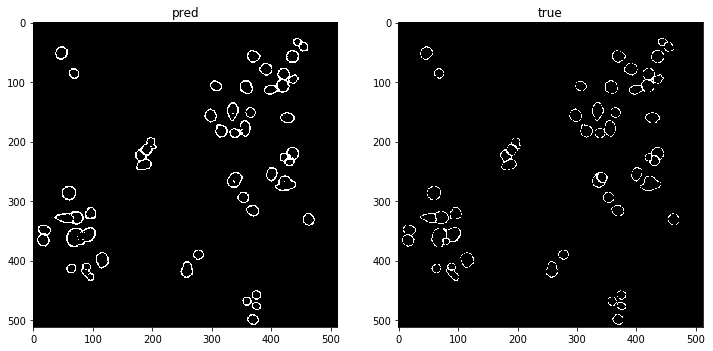

In [34]:
for p, g in zip(prediction, gt):
    p_im = Image.fromarray(p.astype(np.uint8) * 255, mode='L')
    g_im = Image.fromarray(g.astype(np.uint8) * 255, mode='L')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(p_im)
    plt.title('pred')
    plt.subplot(1, 2, 2)
    plt.imshow(g_im)
    plt.title('true')
    plt.show()

### Еее работает, stack more layers

In [35]:
unet.eval()
for name in test_images_list:
    image_name = "{}-actin.DIB.bmp".format(name)
    mask_name = "{}-cells.png".format(name)
    image = Image.open(os.path.join(test_img_path, image_name))
    image = val_image_transform(image)
    image = torch.stack([image])
    with torch.cuda.device(1):
        pred = unet(image.cuda())
    pred = torch.squeeze(pred)
    prediction = pred.detach().cpu().numpy()
    prediction = prediction.argmax(axis=0)
    pred_mask = Image.fromarray(prediction.astype(np.uint8) * 255, mode='L')
    pred_mask.save("{}-actin.DIB.png".format(name))

## Попробуем c кропом на обучении

In [288]:
means = (0.20166926, 0.28220195, 0.31729624)
stds = (0.20769505, 0.18813899, 0.16692209)

train_image_transform = transforms.Compose([
    transforms.RandomCrop(size=300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

train_mask_transform = transforms.Compose([
    transforms.RandomCrop(size=300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180)
])

val_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

val_mask_transform = None

In [289]:
train_dataset = ImgDataset(image_dir=train_img_path,
                           image_names=train_images_list,
                           image_transform=train_image_transform,
                           mask_dir=train_mask_path,
                           mask_transform=train_mask_transform)

val_dataset = ImgDataset(image_dir=train_img_path,
                         image_names=val_images_list,
                         image_transform=val_image_transform,
                         mask_dir=train_mask_path,
                         mask_transform=val_mask_transform)

In [290]:
len(train_dataset), len(val_dataset)

(32, 9)

In [291]:
train_dl = data_utils.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = data_utils.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [292]:
with torch.cuda.device(1):
    unet = UNet(2, in_channels=3, depth=3, start_filts=16, batchnorm=True, activation='leaky').cuda()

In [293]:
train_loss, train_iou, val_loss, val_iou = [], [], [], []
optim = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [316]:
class_weights = [1, 3]
with torch.cuda.device(1):
    class_weights_tensor = torch.FloatTensor(class_weights).cuda()

In [317]:
from IPython.display import clear_output

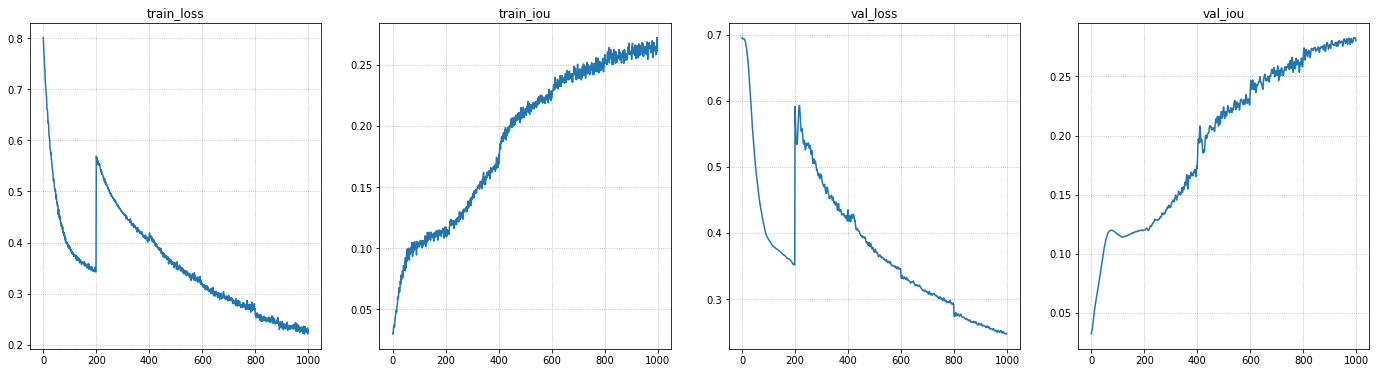

100%|██████████| 200/200 [02:59<00:00,  1.12it/s]


In [318]:
for i in tqdm(range(200)):
    unet.train()
    for X, y in train_dl:
        with torch.cuda.device(1):
            X = Variable(X).cuda()
            y = Variable(y).cuda()
            output = unet(X)
            loss_ = nn.CrossEntropyLoss(weight=class_weights_tensor)(output, y)
            loss_.backward()
            optim.step()
            optim.zero_grad()
        train_loss.append(loss_.item())
        pred = output.detach().cpu().numpy()
        pred = np.argmax(pred, axis=1)
        gt = y.detach().cpu().numpy()
        train_iou.append(calc_iou(pred, gt))
    unet.eval()
    loss, iou = get_loss_and_iou(val_dl, unet, class_weights=class_weights)
    val_loss.append(loss)
    val_iou.append(iou)
    
    clear_output(True)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1)
    plt.plot(train_loss)
    plt.title('train_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 2)
    plt.plot(train_iou)
    plt.title('train_iou')
    plt.grid(ls=':')
    plt.subplot(1, 4, 3)
    plt.plot(val_loss)
    plt.title('val_loss')
    plt.grid(ls=':')
    plt.subplot(1, 4, 4)
    plt.plot(val_iou)
    plt.title('val_iou')
    plt.grid(ls=':')
    plt.show()

In [319]:
unet.eval()
for X, y in test_dl:
    with torch.cuda.device(1):
        X = Variable(X).cuda()
        output = unet(X)
    prediction = output.detach().cpu().numpy()
    gt = y.detach().cpu().numpy()

In [320]:
prediction.shape, gt.shape

((7, 2, 512, 512), (7, 512, 512))

In [321]:
prediction = prediction.argmax(axis=1)
prediction.shape

(7, 512, 512)

In [322]:
print("Test IOU: {}".format(calc_iou(prediction, gt)))

Test IOU: 0.25563578460336694


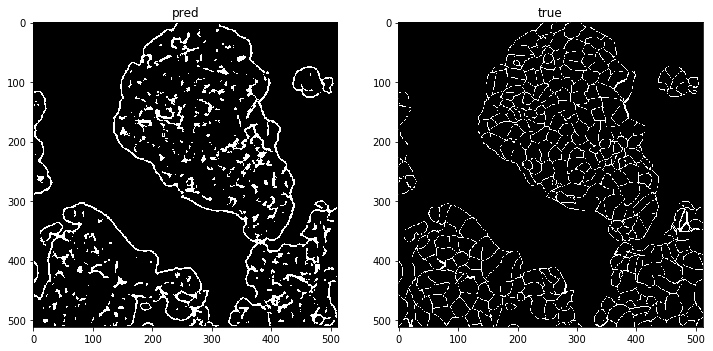

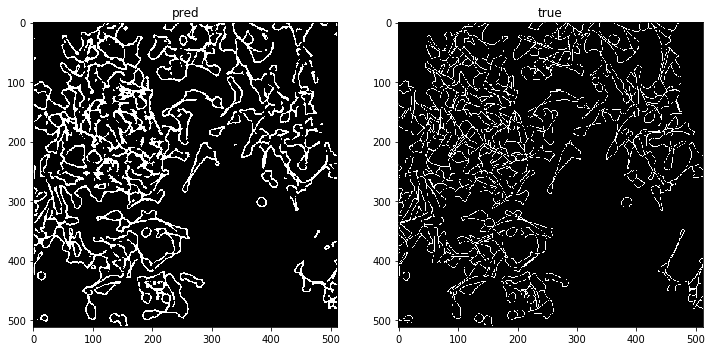

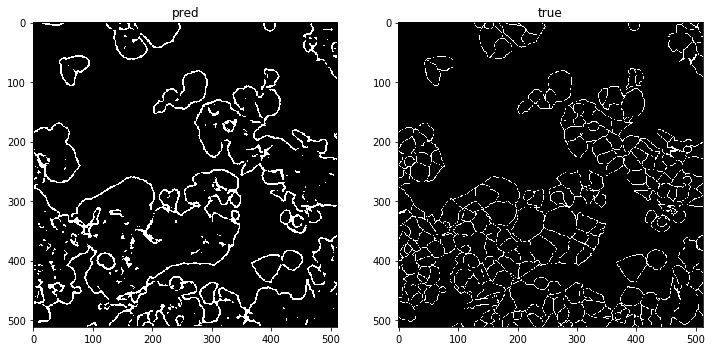

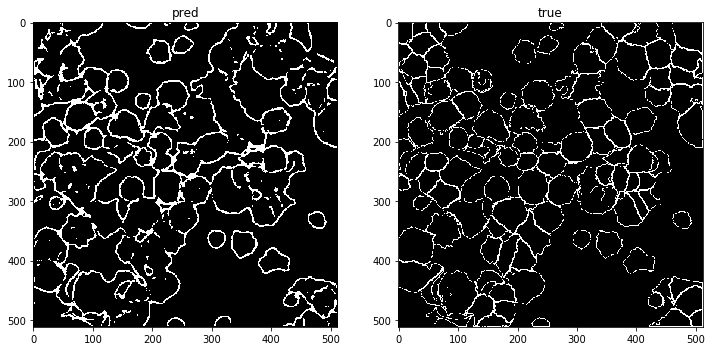

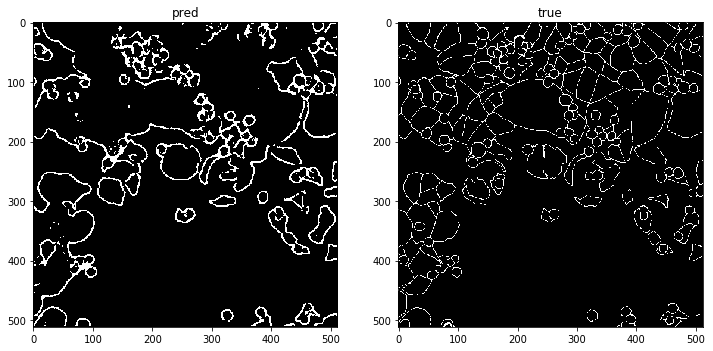

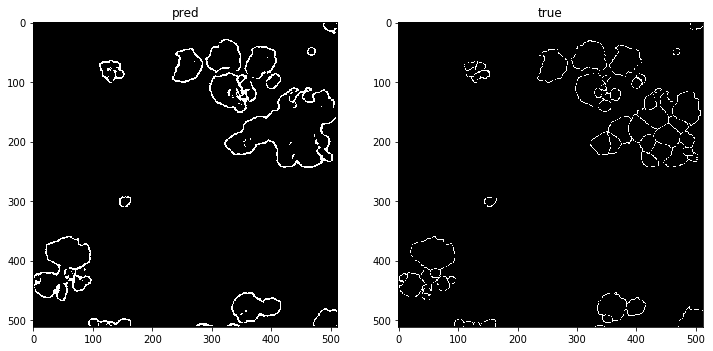

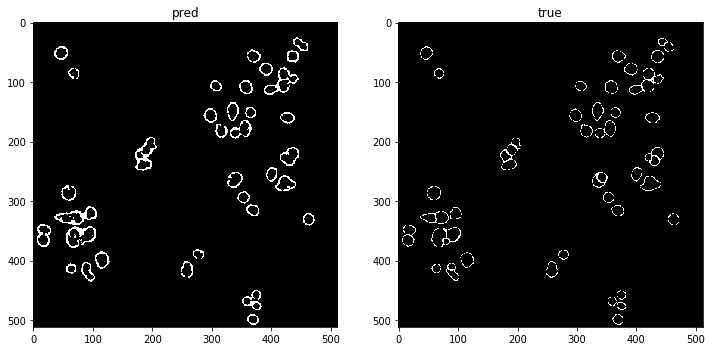

In [323]:
for p, g in zip(prediction, gt):
    p_im = Image.fromarray(p.astype(np.uint8) * 255, mode='L')
    g_im = Image.fromarray(g.astype(np.uint8) * 255, mode='L')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(p_im)
    plt.title('pred')
    plt.subplot(1, 2, 2)
    plt.imshow(g_im)
    plt.title('true')
    plt.show()

### Не кропы не помогли